In [1]:
import numpy as np
import pandas as pd

import warnings

import matplotlib.pyplot as plt
import seaborn as sns
from termcolor import colored

from strsimpy.levenshtein import Levenshtein
from Levenshtein import distance

import os
from sklearn import preprocessing
import statsmodels.api as sm

import calendar
from datetime import datetime
import datetime
import time

from itertools import product
from math import ceil
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.cluster import KMeans
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest

import lightgbm as lgb

warnings.filterwarnings(action='ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

In [2]:
items = pd.read_csv('Input/items.csv', dtype={'item_name': 'str', 'item_id': 'int32', 
                                                 'item_category_id': 'int32'})
shops = pd.read_csv('Input/shops.csv')
categories = pd.read_csv('Input/item_categories.csv')
train = pd.read_csv('Input/sales_train.csv').replace({'shop_id':{ 0: 57, 1: 58, 11: 10, 40: 39}})
test = pd.read_csv('Input/test.csv')

In [3]:
train.date=train.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))

train['day'] = train['date'].dt.day
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year
train['weekday'] = train['date'].dt.dayofweek

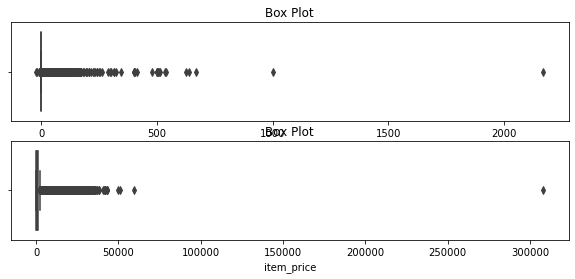

In [4]:
plt.figure(figsize=(10, 4))
plt.subplot(2,1,1)
plt.title("Box Plot")
sns.boxplot(train['item_cnt_day'])
plt.subplot(2,1,2)
plt.title("Box Plot")
sns.boxplot(train['item_price'])
plt.show()

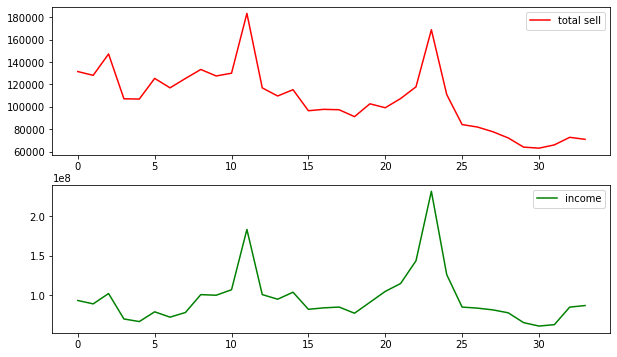

In [5]:
grouped = train.groupby(['date_block_num'])['item_cnt_day'].sum()
grouped2 = train.groupby(['date_block_num'])['item_price'].mean()
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(grouped, label='total sell', color='r')
plt.legend()
plt.subplot(2,1,2)
plt.plot(grouped*grouped2, label='income', color='g')
plt.legend()
plt.show()

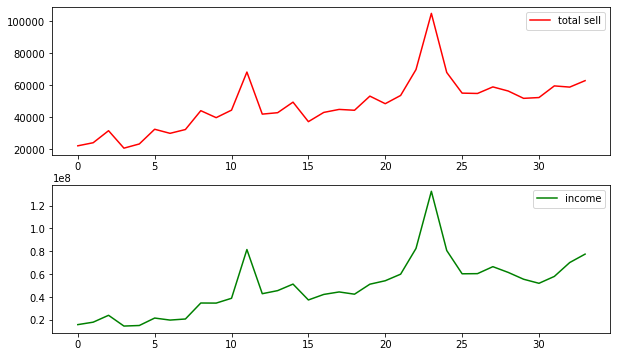

In [6]:
a = train[train['shop_id'].isin(test.shop_id.unique())]
a = a[a['item_id'].isin(test.item_id.unique())]

grouped = a.groupby(['date_block_num'])['item_cnt_day'].sum()
grouped2 = a.groupby(['date_block_num'])['item_price'].mean()
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(grouped, label='total sell', color='r')
plt.legend()
plt.subplot(2,1,2)
plt.plot(grouped*grouped2, label='income', color='g')
plt.legend()
plt.show()

In [7]:
train = train[train['item_cnt_day']<1000]
train = train[train['item_price']<100000]

In [8]:
df = [] 
for block_num in train['date_block_num'].unique():
    cur_shops = train.loc[train['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = train.loc[train['date_block_num'] == block_num, 'item_id'].unique()
    df.append(np.array(list(product(*[cur_shops, cur_items, [block_num]]))))

df = pd.DataFrame(np.vstack(df), columns=['shop_id', 'item_id', 'date_block_num'])

**ITEMS**

In [9]:
def similiars(df, columns):

    shop_name_list = list(df[columns].unique())


    Matrix = np.zeros((len(shop_name_list),len(shop_name_list)))

    for i in range(len(shop_name_list)):
        for j in range(len(shop_name_list)):
            Matrix[i,j] = distance(shop_name_list[i],shop_name_list[j]) / min(len(shop_name_list[i]), len(shop_name_list[j]))

    check = []
    ids = []

    for i in range(len(Matrix)):
        for j in range(len(Matrix[i])):
            if 0 < Matrix[i][j] < 0.3:

                if (shop_name_list[i], shop_name_list[j]) not in check:
                    check.append((shop_name_list[j], shop_name_list[i]))


    for k in range(len(check)):
        print(check[k])

In [10]:
categories['categories'] = categories['item_category_name'].str.split('-').map(lambda x: x[0])
categories['sub_categories'] = categories['item_category_name'].str.split('-').map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())

In [11]:
items = items.merge(categories)

In [12]:
similiars(items, 'sub_categories')
similiars(items, 'categories')

('CD фирменного производства', 'CD локального производства')
('Чистые носители (шпиль)', 'Чистые носители (штучные)')
('Игры MAC ', 'Игры PC ')
('Служебные', 'Служебные ')
('Чистые носители (шпиль)', 'Чистые носители (штучные)')


In [13]:
items.loc[items.categories=='Служебные ', "categories"] = 'Служебные'

items['categories_code'] = LabelEncoder().fit_transform(items['categories'])
items['sub_categories_code'] = LabelEncoder().fit_transform(items['sub_categories'])

temp = train.merge(items)

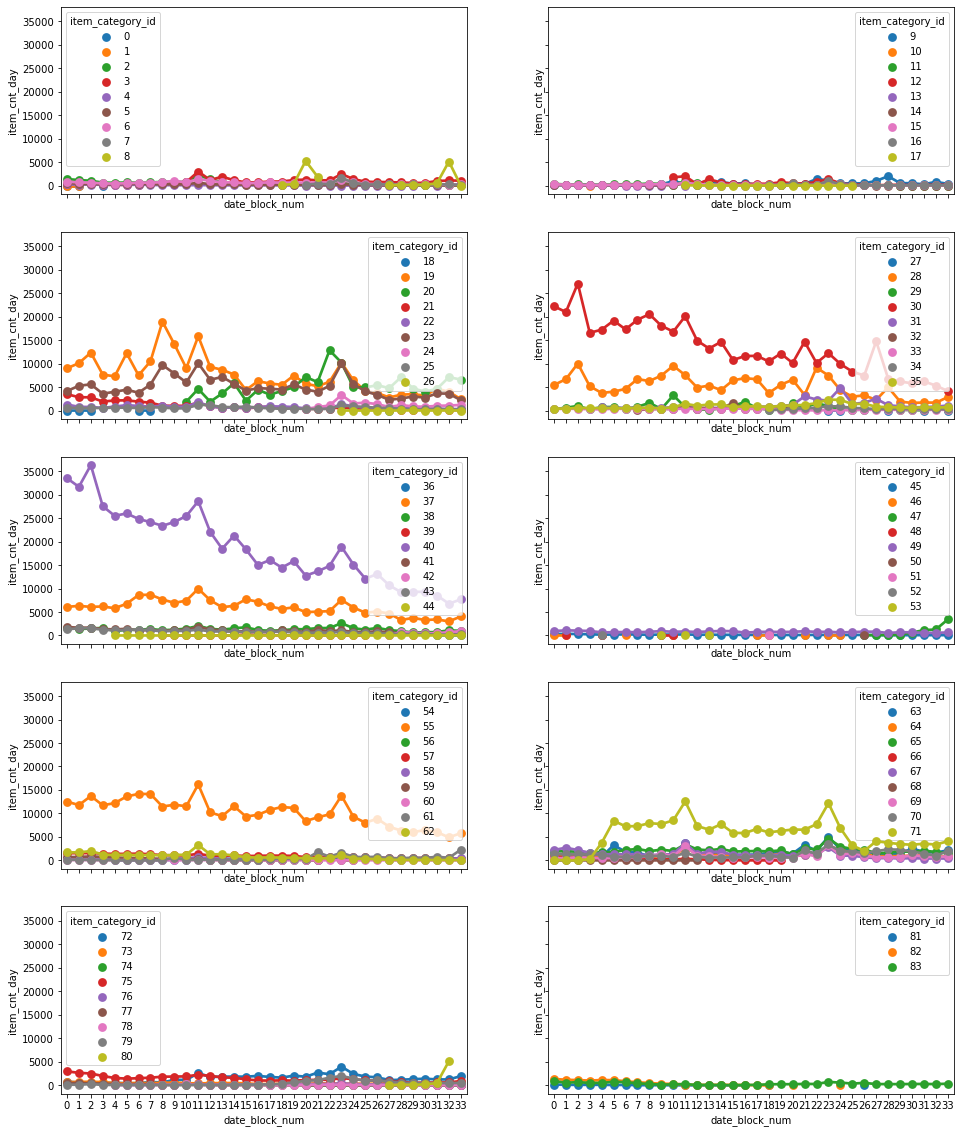

In [14]:
grouped = pd.DataFrame(temp.groupby(['item_category_id', 'date_block_num'])['item_cnt_day'].sum().reset_index())
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(grouped.item_category_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_day', hue='item_category_id', data=grouped[np.logical_and(count*id_per_graph <= grouped['item_category_id'], grouped['item_category_id'] < (count+1)*id_per_graph)], ax=axes[i][j])
        count += 1

**SHOPS**

In [15]:
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops.loc[shops['shop_name'].str.contains(r'!Якутск Орджоникидзе, 56 фран'), 'shop_name'] = 'Якутск Орджоникидзе, 56 фран'
shops.loc[shops['shop_name'].str.contains(r'!Якутск ТЦ "Центральный" фран'), 'shop_name'] = 'Якутск ТЦ "Центральный" фран'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])

In [16]:
shops['shop_type'] = 'regular'
shops.loc[shops['shop_name'].str.contains(r'ТК'), 'shop_type'] = 'tc'
shops.loc[shops['shop_name'].str.contains('ТЦ|ТРЦ|МТРЦ|ТРК'), 'shop_type'] = 'mall'
shops.loc[shops['shop_id'].isin([9,20]), 'shop_type'] = 'special'
shops.loc[shops['shop_id'].isin([12,55]), 'shop_type'] = 'online'
shops.loc[shops['shop_id'].isin([12,55]), 'city'] = 'online'
shops['shop_type_code'] = LabelEncoder().fit_transform(shops['shop_type'])

In [17]:
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

df = pd.merge(df, group, on=['date_block_num','shop_id','item_id'], how='left')
df['item_cnt_month'] = (df['item_cnt_month'].fillna(0).clip(0,20).astype(np.float32))

In [18]:
grouped = train.groupby(['shop_id', 'weekday']).agg({'item_cnt_day':'sum'}).reset_index()
temp = train.groupby('shop_id').agg({'item_cnt_day':'sum'}).reset_index()
grouped = pd.merge(grouped, temp, on='shop_id', how='left')
grouped.columns = ['shop_id', 'weekday', 'shop_sales_day', 'shop_sales_total']
grouped['day_sell_quality'] = grouped['shop_sales_day']/grouped['shop_sales_total']

start_time = '2013-01-01'
end_time = end='2015-11-30'

dates = pd.DataFrame(data={'date':pd.date_range(start='2013-01-01',end='2015-11-30')})
dates['weekday'] = dates.date.dt.dayofweek
dates['month'] = dates.date.dt.month
dates['year'] = dates.date.dt.year - 2013
dates['date_block_num'] = dates.year * 12 + dates.month - 1
dates['first_day_of_month'] = dates.date.dt.dayofyear
dates['first_day_of_month'] += 365 * dates['year']
dates = dates.join(grouped.set_index('weekday'), on='weekday')
dates = dates.groupby(['date_block_num','shop_id','month','year']).agg(
    {'day_sell_quality':'sum','first_day_of_month':'min'}).reset_index()

In [19]:
df = pd.merge(df, shops, on='shop_id', how='left')
df = pd.merge(df, items, on='item_id', how='left')

In [20]:
df = df.fillna(0)

**Lagged Features**

In [21]:
def lag(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [22]:
temp = df.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_shop_avg_item_cnt']
temp.reset_index(inplace=True)

df = pd.merge(df, temp, on=['date_block_num', 'shop_id'], how='left')

df = lag(df, [1, 2, 3, 4], 'date_shop_avg_item_cnt')
df = df.drop(columns=['date_shop_avg_item_cnt'])

In [23]:
temp = df.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_city_avg_item_cnt']
temp.reset_index(inplace=True)

df = pd.merge(df, temp, on=['date_block_num', 'city_code'], how='left')

df = lag(df, [1, 2], 'date_city_avg_item_cnt')
df = df.drop(columns=['date_city_avg_item_cnt'])

In [24]:
temp = df.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_cat_avg_item_cnt']
temp.reset_index(inplace=True)

df = pd.merge(df, temp, on=['date_block_num', 'item_category_id'], how='left')

df = lag(df, [1, 2], 'date_cat_avg_item_cnt')
df = df.drop(columns=['date_cat_avg_item_cnt'])

In [25]:
temp = df.groupby(['date_block_num', 'categories_code']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_main_cat_avg_item_cnt']
temp.reset_index(inplace=True)

df = pd.merge(df, temp, on=['date_block_num', 'categories_code'], how='left')


df = lag(df, [1, 2, 4], 'date_main_cat_avg_item_cnt')
df = df.drop(columns=['date_main_cat_avg_item_cnt'])

In [26]:
temp = df.groupby(['date_block_num', 'sub_categories_code']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_sub_cat_avg_item_cnt']
temp.reset_index(inplace=True)

df = pd.merge(df, temp, on=['date_block_num', 'sub_categories_code'], how='left')

df = lag(df, [1, 2, 3], 'date_sub_cat_avg_item_cnt')
df = df.drop(columns=['date_sub_cat_avg_item_cnt'])

In [27]:
temp = df.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_item_avg_item_cnt']
temp.reset_index(inplace=True)

df = pd.merge(df, temp, on=['date_block_num', 'item_id'], how='left')

df = lag(df, [1], 'date_item_avg_item_cnt')
df = df.drop(columns=['date_item_avg_item_cnt'])

In [28]:
temp = df.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_shop_cat_avg_item_cnt']
temp.reset_index(inplace=True)

df = pd.merge(df, temp, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')

df = lag(df, [1], 'date_shop_cat_avg_item_cnt')
df = df.drop(columns=['date_shop_cat_avg_item_cnt'])

In [29]:
temp = df.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_avg_item_cnt']
temp.reset_index(inplace=True)

df = pd.merge(df, temp, on=['date_block_num'], how='left')


df = lag(df, [1, 2, 3], 'date_avg_item_cnt')
df = df.drop(columns=['date_avg_item_cnt'])

In [30]:
temp = df.groupby(['date_block_num', 'shop_id', 'categories_code']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_shop_main_cat_avg_item_cnt']
temp.reset_index(inplace=True)

df = pd.merge(df, temp, on=['date_block_num', 'shop_id', 'categories_code'], how='left')

df = lag(df, [1, 2], 'date_shop_main_cat_avg_item_cnt')
df = df.drop(columns=['date_shop_main_cat_avg_item_cnt'])

In [31]:
temp = df.groupby(['date_block_num', 'shop_id', 'sub_categories_code']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_shop_sub_cat_avg_item_cnt']
temp.reset_index(inplace=True)

df = pd.merge(df, temp, on=['date_block_num', 'shop_id', 'sub_categories_code'], how='left')

df = lag(df, [1, 2], 'date_shop_sub_cat_avg_item_cnt')
df = df.drop(columns=['date_shop_sub_cat_avg_item_cnt'])

In [32]:
temp = df.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_item_city_avg_item_cnt']
temp.reset_index(inplace=True)

df = pd.merge(df, temp, on=['date_block_num', 'item_id', 'city_code'], how='left')

df = lag(df, [1], 'date_item_city_avg_item_cnt')
df = df.drop(columns=['date_item_city_avg_item_cnt'])

In [33]:
df = lag(df, [1,2,3,6,12], 'item_cnt_month')

In [34]:
df['qmean'] = df[['item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3']].mean(skipna=True, axis=1)

**Features of Columns**

In [35]:
temp = df.groupby(['item_category_id']).agg({'item_cnt_month': ['mean']})
temp.columns = ['item_category_shop_id_mean']
temp.reset_index(inplace=True)

df = pd.merge(df, temp, on=['item_category_id'], how='left')

In [36]:
temp = df.groupby(['shop_id']).agg({'item_cnt_month': ['mean']})
temp.columns = ['shop_mean']
temp.reset_index(inplace=True)

df = pd.merge(df, temp, on=['shop_id'], how='left')

In [37]:
temp = df.groupby(['categories']).agg({'item_cnt_month': ['mean']})
temp.columns = ['category_mean']
temp.reset_index(inplace=True)

df = pd.merge(df, temp, on=['categories'], how='left')

In [38]:
temp = df.groupby(['categories', 'sub_categories']).agg({'item_cnt_month': ['mean']})
temp.columns = ['category_and_sub_mean']
temp.reset_index(inplace=True)

df = pd.merge(df, temp, on=['categories', 'sub_categories'], how='left')

In [39]:
temp = df.groupby(['shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
temp.columns = ['shop_id_item_category_mean']
temp.reset_index(inplace=True)

df = pd.merge(df, temp, on=['shop_id', 'item_category_id'], how='left')

In [40]:
df.sample(50)

,shop_id,item_id,date_block_num,item_cnt_month,shop_name,city,city_code,shop_type,shop_type_code,item_name,item_category_id,item_category_name,categories,sub_categories,categories_code,sub_categories_code,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_4,date_city_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_2,date_cat_avg_item_cnt_lag_1,date_cat_avg_item_cnt_lag_2,date_main_cat_avg_item_cnt_lag_1,date_main_cat_avg_item_cnt_lag_2,date_main_cat_avg_item_cnt_lag_4,date_sub_cat_avg_item_cnt_lag_1,date_sub_cat_avg_item_cnt_lag_2,date_sub_cat_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_avg_item_cnt_lag_1,date_avg_item_cnt_lag_2,date_avg_item_cnt_lag_3,date_shop_main_cat_avg_item_cnt_lag_1,date_shop_main_cat_avg_item_cnt_lag_2,date_shop_sub_cat_avg_item_cnt_lag_1,date_shop_sub_cat_avg_item_cnt_lag_2,date_item_city_avg_item_cnt_lag_1,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,qmean,item_category_shop_id_mean,shop_mean,category_mean,category_and_sub_mean,shop_id_item_category_mean
3544180,50,8303,9,0.0,"Тюмень ТЦ ""Гудвин""",Тюмень,24,mall,0,АНЖЕЛИКА (регион),40,Кино - DVD,Кино,DVD,11,4,0.397664,0.435811,0.360262,0.391602,0.315325,0.347528,0.227597,0.238354,0.213528,0.228983,0.208602,0.227597,0.238354,0.225074,0.088889,0.296193,0.308129,0.316709,0.276885,0.274924,0.301226,0.296193,0.330723,0.000000,0.0,0.0,0.0,1.0,NaN,0.000000,0.245255,0.306724,0.218503,0.245255,0.269445
5221704,47,14304,14,0.0,"Сургут ТРЦ ""Сити Молл""",Сургут,22,mall,0,МАЛЕНЬКИЙ ПРИНЦ: ПЛАНЕТА ВЕТРОВ/ПЛАНЕТА МУЗЫКИ...,40,Кино - DVD,Кино,DVD,11,4,0.265489,0.271090,0.320548,0.227346,0.265489,0.271090,0.238972,0.257571,0.203646,0.230563,0.221425,0.238972,0.257571,0.291505,0.217391,0.144857,0.307474,0.311352,0.411299,0.112646,0.142953,0.144857,0.153931,0.000000,0.0,0.0,0.0,0.0,NaN,0.000000,0.245255,0.264870,0.218503,0.245255,0.124781
80720,27,6201,0,0.0,"Москва ТЦ ""МЕГА Белая Дача II""",Москва,13,mall,0,SADE The Best Of Sade (фирм.),56,Музыка - CD фирменного производства,Музыка,CD фирменного производства,13,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.082955,0.535977,0.173571,0.082955,0.208433
10084456,55,14994,30,0.0,Цифровой склад 1С-Онлайн,online,27,online,1,Маска Plants vs Zombies Zombie Mask,61,Подарки - Атрибутика,Подарки,Атрибутика,14,20,0.266488,0.265190,0.269540,0.259125,0.266488,0.265190,0.140698,0.120942,0.274552,0.261284,0.276568,0.140698,0.120942,0.108075,0.046512,0.000000,0.264276,0.259542,0.243033,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,NaN,0.000000,0.133312,0.195565,0.290093,0.133312,0.000000
8397203,12,2537,24,0.0,Интернет-магазин ЧС,online,7,online,1,DEEP PURPLE Now What?! Live Tapes 2LP,58,Музыка - Винил,Музыка,Винил,13,27,0.396821,0.275862,NaN,0.194202,0.396821,0.275862,0.061760,0.050630,0.260371,0.192006,0.152268,0.061760,0.050630,NaN,0.061224,0.149813,0.452913,0.317534,NaN,0.169267,0.077110,0.149813,0.085106,0.000000,0.0,0.0,NaN,0.0,NaN,0.000000,0.046038,0.184126,0.173571,0.046038,0.064677
4837976,27,17947,13,0.0,"Москва ТЦ ""МЕГА Белая Дача II""",Москва,13,mall,0,РОМЕО И ДЖУЛЬЕТТА,40,Кино - DVD,Кино,DVD,11,4,0.635810,0.783548,0.506490,0.458142,0.494742,0.645816,0.257571,0.291505,0.230563,0.269904,0.209953,0.257571,0.291505,0.244913,1.652174,0.341396,0.311352,0.411299,0.303260,0.374750,0.424703,0.341396,0.384883,3.000000,3.0,2.0,1.0,0.0,NaN,2.000000,0.245255,0.535977,0.218503,0.245255,0.307041
9728553,34,6090,29,0.0,"Н.Новгород ТРЦ ""РИО""",Н.Новгород,15,mall,0,"Rayman Origins (Classics) [Xbox 360, русская в...",23,Игры - XBOX 360,Игры,XBOX 360,5,16,0.074579,0.067568,0.070700,0.064100,0.162408,0.156684,0.388636,0.296705,0.487498,0.369372,0.584099,0.382509,0.302081,0.438209,0.863636,0.133333,0.259542,0.243033,0.274499,0.263158,0.172757,0.122807,0.120879,0.500000,0.0,0.0,0.0,1.0,NaN

In [41]:
df = df.fillna(0)

In [42]:
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

df = pd.merge(df, group, on=['item_id'], how='left')
df['item_avg_item_price'] = df['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

df = pd.merge(df, group, on=['date_block_num','item_id'], how='left')
df['date_item_avg_item_price'] = df['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
df = lag(df, lags, 'date_item_avg_item_price')

for i in lags:
    df['delta_price_lag_'+str(i)] = (df['date_item_avg_item_price_lag_'+str(i)] - df['item_avg_item_price']) / df['item_avg_item_price']
    
def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
df['delta_price_lag'] = df.apply(select_trend, axis=1)
df['delta_price_lag'] = df['delta_price_lag'].astype(np.float16)
df['delta_price_lag'].fillna(0, inplace=True)    


fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

df.drop(fetures_to_drop, axis=1, inplace=True)

In [43]:
train['revenue'] = train['item_cnt_day'] * train['item_price']
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

df = pd.merge(df, group, on=['date_block_num','shop_id'], how='left')
df['date_shop_revenue'] = df['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

df = pd.merge(df, group, on=['shop_id'], how='left')
df['shop_avg_revenue'] = df['shop_avg_revenue'].astype(np.float32)

df['delta_revenue'] = (df['date_shop_revenue'] - df['shop_avg_revenue']) / df['shop_avg_revenue']
df['delta_revenue'] = df['delta_revenue'].astype(np.float16)

df = lag(df, [1], 'delta_revenue')

df.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)

In [44]:
df = df.merge(dates)
df['item_age'] = (df['date_block_num'] - df.groupby('item_id')['date_block_num'].transform('min')).astype('int8')

In [45]:
df = df.drop(columns=['shop_name', 'city', 'shop_type', 'item_name', 'item_category_name', 'categories', 'sub_categories'])

In [46]:
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

df_all = fill_na(df)

In [47]:
df_all = df_all[df_all.date_block_num > 11]

In [48]:
df_all = df_all.sort_values('date_block_num')

In [49]:
X_train = df_all[df_all.date_block_num < 33].drop(['item_cnt_month'], axis=1).fillna(0)
Y_train = df_all[df_all.date_block_num < 33]['item_cnt_month']
X_valid = df_all[df_all.date_block_num == 33].drop(['item_cnt_month'], axis=1).fillna(0)
Y_valid = df_all[df_all.date_block_num == 33]['item_cnt_month']
X_test = df_all[df_all.date_block_num == 34].drop(['item_cnt_month'], axis=1).fillna(0)

In [50]:
df.columns

Index(['shop_id', 'item_id', 'date_block_num', 'item_cnt_month', 'city_code',
       'shop_type_code', 'item_category_id', 'categories_code',
       'sub_categories_code', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_4', 'date_city_avg_item_cnt_lag_1',
       'date_city_avg_item_cnt_lag_2', 'date_cat_avg_item_cnt_lag_1',
       'date_cat_avg_item_cnt_lag_2', 'date_main_cat_avg_item_cnt_lag_1',
       'date_main_cat_avg_item_cnt_lag_2', 'date_main_cat_avg_item_cnt_lag_4',
       'date_sub_cat_avg_item_cnt_lag_1', 'date_sub_cat_avg_item_cnt_lag_2',
       'date_sub_cat_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_1',
       'date_shop_cat_avg_item_cnt_lag_1', 'date_avg_item_cnt_lag_1',
       'date_avg_item_cnt_lag_2', 'date_avg_item_cnt_lag_3',
       'date_shop_main_cat_avg_item_cnt_lag_1',
       'date_shop_main_cat_avg_item_cnt_lag_2',
       'date_shop_sub_cat_avg_item_cnt_lag_1',
      

In [51]:
feature_name = X_train.columns.tolist()

params = {
    'objective': 'rmse',
    'metric': 'rmse',

}

feature_name_indexes = ['city_code',
       'shop_type_code', 'categories_code',
       'sub_categories_code']

lgb_train = lgb.Dataset(X_train, Y_train)
lgb_eval = lgb.Dataset(X_valid, Y_valid, reference=lgb_train)

evals_result = {}
gbm = lgb.train(
        params, 
        lgb_train,
        num_boost_round=3000,
        valid_sets=(lgb_train, lgb_eval), 
        feature_name = feature_name,
        categorical_feature = feature_name_indexes,
        verbose_eval=5, 
        evals_result = evals_result,
        early_stopping_rounds= 30) 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.315978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7306
[LightGBM] [Info] Number of data points in the train set: 6115195, number of used features: 50
[LightGBM] [Info] Start training from score 0.292187
Training until validation scores don't improve for 30 rounds
[5]	training's rmse: 1.00255	valid_1's rmse: 0.98758
[10]	training's rmse: 0.916072	valid_1's rmse: 0.930114
[15]	training's rmse: 0.87584	valid_1's rmse: 0.901228
[20]	training's rmse: 0.854798	valid_1's rmse: 0.892916
[25]	training's rmse: 0.841465	valid_1's rmse: 0.886318
[30]	training's rmse: 0.83265	valid_1's rmse: 0.884139
[35]	training's rmse: 0.825264	valid_1's rmse: 0.884205
[40]	training's rmse: 0.819365	valid_1's rmse: 0.883138
[45]	training's rmse: 0.814945	valid_1's rmse: 0.886067
[50]	training's rmse: 0.81126

In [52]:
xgb_model = XGBRegressor(max_depth=8,
                        n_estimators=500,
                        min_child_weight=1000,
                        colsample_bytree=0.7,
                        subsample=0.7,
                        eta=0.3,
                        seed=0)
xgb_model.fit(X_train,
            Y_train,
            eval_metric="rmse",
            eval_set=[(X_train, Y_train), (X_valid, Y_valid)],
            verbose=20,
            early_stopping_rounds=20)

[0]	validation_0-rmse:1.06482	validation_1-rmse:1.04083
[20]	validation_0-rmse:0.81645	validation_1-rmse:0.88825
[40]	validation_0-rmse:0.80498	validation_1-rmse:0.89408
[43]	validation_0-rmse:0.80348	validation_1-rmse:0.89656


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             eta=0.3, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=8, min_child_weight=1000, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=0, subsample=0.7,
             tree_method='approx', validate_parameters=1, verbosity=None)

In [53]:
import tensorflow
tensorflow.random.set_seed(1)
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import backend as K

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 


model = Sequential()
model.add(Dense(51, input_dim=50, kernel_initializer='normal', activation='relu'))
model.add(Dense(2670, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

model.compile(loss = root_mean_squared_error, optimizer='adam', metrics=[root_mean_squared_error,'mae'])
history=model.fit(X_train, Y_train, epochs=5, batch_size=150, verbose=1, validation_data=(X_valid, Y_valid))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 51)                2601      
_________________________________________________________________
dense_1 (Dense)              (None, 2670)              138840    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2671      
Total params: 144,112
Trainable params: 144,112
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
40768/40768 [==============================] - 203s 5ms/step - loss: 1.0588 - root_mean_squared_error: 1.0588 - mae: 0.5328 - val_loss: 0.6178 - val_root_mean_squared_error: 0.6178 - val_mae: 0.3119
Epoch 2/5
40768/40768 [==============================] - 197s 5ms/step - loss: 0.8435 - root_mean_squared_error: 0.8435 - mae: 0.3408 - val_loss: 0.6562 - val_root_mean_sq

ValueError: Expect x to be a non-empty array or dataset.

In [58]:
mean_squared_error(Y_valid, model.predict(X_valid), squared=False)

0.9472844